In [1]:
import os
import itertools, collections
import numpy, scipy, pandas
import scipy.signal
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from imp import reload
import seaborn

from pgtools import toolbox, myplots
import pygbrowse

import empdist
import peas
from peas.utilities import log_print

In [2]:
seaborn.__version__

'0.9.0'

## Use empirical dataset

In [3]:
hic_corrs_fname = '/home/dskola/projects/coupled_peaks/hic/c57_hic_corrs_chr19.tsv'
hic_corrs = pandas.read_csv(hic_corrs_fname, sep='\t', index_col=0)

## Trim matrix

In [4]:
from peas.arrayfuncs import replace_nans_diagonal_means, compute_vector_trim_points, compute_matrix_trim_points, \
    create_diagonal_distance_matrix, create_data_masks

def trim_data_matrix(input_matrix):
    row_start_trim_point, row_end_trim_point, col_start_trim_point, col_end_trim_point = compute_matrix_trim_points(
        input_matrix)
    trimmed_matrix = input_matrix[row_start_trim_point:row_end_trim_point, col_start_trim_point:col_end_trim_point]
    log_print('trimmed {} x {} matrix to remove contiguous NaNs, now {} x {}.'.format(*input_matrix.shape,
                                                                                      *trimmed_matrix.shape))
    return trimmed_matrix

In [5]:
trimmed_corrs = replace_nans_diagonal_means(trim_data_matrix(hic_corrs.values))

2018-Aug-30 11:50:00	trimmed 6134 x 6134 matrix to remove contiguous NaNs, now 5825 x 5825.


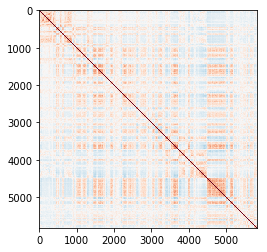

In [7]:
plt.imshow(trimmed_corrs, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

In [8]:
%time real_means = peas.scoring.compute_mean_table_2d(trimmed_corrs, end_diagonal=1000)

CPU times: user 1.75 s, sys: 204 ms, total: 1.96 s
Wall time: 1.96 s


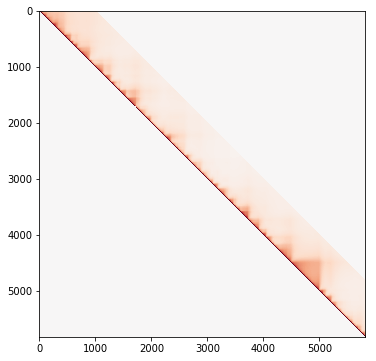

In [9]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(real_means, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

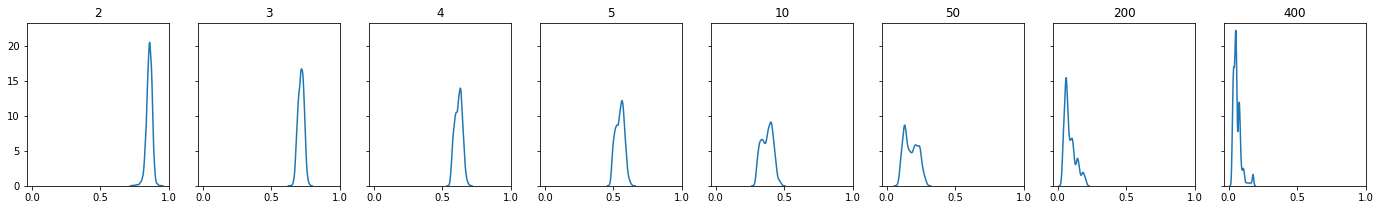

In [29]:
REGION_SIZES = (2, 3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=True, sharey=True)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = numpy.diag(real_means, region_size-1)
    seaborn.kdeplot(region_means, ax=ax)
    ax.set_title(region_size)

In [12]:
reload(peas)

<module 'peas' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/__init__.py'>

In [19]:
target_pvalue = 1e-4
shuffles_needed = empdist.empirical_pval.compute_number_of_permuted_data_points(target_pvalue, 0.05) / trimmed_corrs.shape[0]
shuffles_needed

686.6951072961374

In [38]:
reload(peas.scoring)
reload(peas.region_stats)

<module 'peas.region_stats' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/region_stats.py'>

In [39]:
shuffled_means = peas.region_stats.generate_permuted_matrix_scores(trimmed_corrs, 
                                                                   num_shuffles=50, 
                                                                   min_region_size=2,
                                                                   max_region_size=1000,
                                                                   random_seed=1)

2018-Aug-30 12:11:45			Setting random seed to 1
2018-Aug-30 12:11:45				permutation 1 of 50
2018-Aug-30 12:11:52				permutation 3 of 50
2018-Aug-30 12:11:58				permutation 5 of 50
2018-Aug-30 12:12:05				permutation 7 of 50
2018-Aug-30 12:12:12				permutation 9 of 50
2018-Aug-30 12:12:19				permutation 11 of 50
2018-Aug-30 12:12:26				permutation 13 of 50
2018-Aug-30 12:12:33				permutation 15 of 50
2018-Aug-30 12:12:40				permutation 17 of 50
2018-Aug-30 12:12:47				permutation 19 of 50
2018-Aug-30 12:12:54				permutation 21 of 50
2018-Aug-30 12:13:01				permutation 23 of 50
2018-Aug-30 12:13:08				permutation 25 of 50
2018-Aug-30 12:13:15				permutation 27 of 50
2018-Aug-30 12:13:22				permutation 29 of 50
2018-Aug-30 12:13:29				permutation 31 of 50
2018-Aug-30 12:13:36				permutation 33 of 50
2018-Aug-30 12:13:43				permutation 35 of 50
2018-Aug-30 12:13:50				permutation 37 of 50
2018-Aug-30 12:13:57				permutation 39 of 50
2018-Aug-30 12:14:04				permutation 41 of 50
2018-Aug-30 

In [42]:
%time shuffled_means = {size:numpy.sort(data) for size, data in shuffled_means.items()}

CPU times: user 5min 15s, sys: 27.5 s, total: 5min 42s
Wall time: 18 s


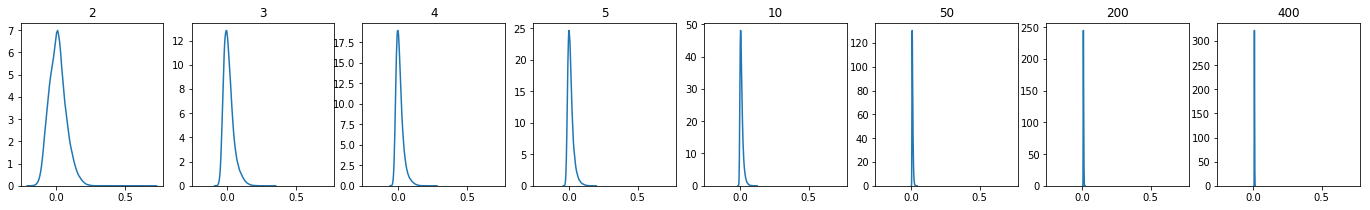

In [43]:
REGION_SIZES = (2, 3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=True, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    seaborn.kdeplot(region_means, ax=ax)
    ax.set_title(region_size)

In [123]:
reload(peas.fitapproxdistros.distributions)

<module 'peas.fitapproxdistros.distributions' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/fitapproxdistros/distributions.py'>

In [114]:
def plot_fit_params(param_dict, param_names, fig_height=3):
    param_df = pandas.DataFrame(param_dict, index=param_names).T

    fig, axes = plt.subplots(1, len(param_names), figsize=(fig_height*len(param_names),fig_height))
    for ax_idx, param_name in enumerate(param_names):
        axes[ax_idx].plot(param_df[param_name])
        axes[ax_idx].set_title(param_name)
        axes[ax_idx].set_ylabel('Value')
        axes[ax_idx].set_xlabel('Sample size')
    fig.tight_layout()
    return fig

In [135]:
class PiecewiseApproxPower2(PiecewiseEmpiricalApprox):
    """
    Stub class for an empirical distribution with methods to:
        1. Fit a power function to the log-survival function of a data sample
        2. Compute the value of the log-survival function for given x.
    """

    def __init__(self, inflection_point, power, scale):
        self.inflection_point = inflection_point
        self.power = power
        self.scale = scale

    @staticmethod
    def _piecewise_logsf(x, inflection_point, power, scale):
        """
        A piecewise power function:
            x < :param:`inflection_point`: 0
            x >= :param:`inflection_point`: :param:`scale` * (:param:`x` - :param:`inflection_point`)**:param:`power`
        """
        assert inflection_point < x[-1], 'Inflection point must be smaller than largest x value to avoid all zeros'
        return numpy.piecewise(x, [x < inflection_point],
                               [lambda x: 0, lambda x: scale * (x - inflection_point) ** power])

    @classmethod
    def fit_with_existing_empirical_logsf(cls, fit_xs, fit_ys, x0=(None, 1), optimization_kwargs={}):
        initial_inflection_point, initial_power = x0

        res = scipy.optimize.basinhopping(func=cls._generate_obj_func(fit_xs, fit_ys),
                                      x0=numpy.array([initial_inflection_point, initial_power]),
                                          minimizer_kwargs={'bounds':((-numpy.inf, fit_xs[-1] - 1e-4),
                                                                      (1, numpy.inf)),
                                                              'method':'L-BFGS-B'},
                                       **optimization_kwargs
                                      )
        inflection_point, power = res.x

        first_pass_ys = cls._piecewise_logsf(fit_xs, inflection_point, power, scale=-1)
        # scale = - (fit_ys[-1] / first_pass_ys[-1])
        scale = -(fit_ys.mean() / first_pass_ys.mean())

        return inflection_point, power, scale

    @classmethod
    def fit(cls, data, is_sorted=False, max_pvalue_std_error=0.05, interp_points=50,
            x0=(None, 1.2), optimization_kwargs={}):

        initial_inflection_point, initial_power = x0

        if not is_sorted:
            data = numpy.sort(data)

        fit_xs, fit_ys = cls._compute_empirical_logsf(data, max_pvalue_std_error=max_pvalue_std_error,
                                                      interp_points=interp_points, is_sorted=True)

        if initial_inflection_point is None:
            initial_inflection_point = data.mean()

        return cls.fit_with_existing_empirical_logsf(fit_xs, fit_ys, x0=(initial_inflection_point, initial_power),
                                                     optimization_kwargs=optimization_kwargs)

    @classmethod
    def _generate_obj_func(cls, fit_xs, fit_ys):
        def obj_func(params):
            inflection_point, power = params
            test_ys = cls._piecewise_logsf(x=fit_xs, inflection_point=inflection_point, power=power, scale=-1)

            score = -cosine_sim(fit_ys, test_ys)

            if numpy.isnan(score) or numpy.isinf(score):
                return numpy.inf

            return score

        return obj_func

    def logsf(self, x):
        return self._piecewise_logsf(x, self.inflection_point, self.power, self.scale)

In [136]:
null_params = peas.fitapproxdistros.helper_funcs.fit_distros(shuffled_means, PiecewiseApproxPower2)
null_param_df = pandas.DataFrame(null_params, index=['inflection_point', 'power', 'scale']).T


2018-Aug-30 13:46:30			size: 2 fit parameters: (-0.10659771955600918, 2.0330433823646814, -60.94510155413252)
2018-Aug-30 13:46:30			size: 3 fit parameters: (-0.04208145613234128, 1.4098882274550404, -55.89542682889682)
2018-Aug-30 13:46:31			size: 4 fit parameters: (-0.022830313801544565, 1.2130682923783793, -57.38126194429243)
2018-Aug-30 13:46:31			size: 5 fit parameters: (-0.013614594871384616, 1.1071945992834686, -59.250086349495085)
2018-Aug-30 13:46:32			size: 6 fit parameters: (-0.008893768184220035, 1.0589208357404345, -63.62799860020474)
2018-Aug-30 13:46:32			size: 7 fit parameters: (-0.005998463075294848, 1.0352749915366126, -69.38657358332418)
2018-Aug-30 13:46:33			size: 8 fit parameters: (-0.0039371348853019005, 1.0179583364679263, -74.77347987282964)
2018-Aug-30 13:46:33			size: 9 fit parameters: (-0.002708090607474647, 1.0209718161976336, -83.195318419396)
2018-Aug-30 13:46:34			size: 10 fit parameters: (-0.001528588715523823, 1.013706121022968, -89.09554801078237)
201

2018-Aug-30 13:47:10			size: 76 fit parameters: (0.006193825108104711, 1.3231299675424888, -1390.6799124610818)
2018-Aug-30 13:47:11			size: 77 fit parameters: (0.006216455600144214, 1.3257307270365086, -1420.770962956235)
2018-Aug-30 13:47:11			size: 78 fit parameters: (0.006223021248965794, 1.3320050339456542, -1472.565653284832)
2018-Aug-30 13:47:12			size: 79 fit parameters: (0.006242637712572921, 1.3345576656267117, -1503.066849023255)
2018-Aug-30 13:47:12			size: 80 fit parameters: (0.006254519163345265, 1.3394906387322496, -1549.5996028772022)
2018-Aug-30 13:47:13			size: 81 fit parameters: (0.006269972464868719, 1.3427734169805152, -1586.0257677737982)
2018-Aug-30 13:47:13			size: 82 fit parameters: (0.00628529628566172, 1.3463380571674588, -1625.4074426681018)
2018-Aug-30 13:47:14			size: 83 fit parameters: (0.006312644848328099, 1.3469410526728058, -1646.4397517705722)
2018-Aug-30 13:47:15			size: 84 fit parameters: (0.006320848036947345, 1.3525208513955607, -1701.62528566693

2018-Aug-30 13:47:46			size: 150 fit parameters: (0.006829062571630415, 1.622838267077986, -9224.85586995112)
2018-Aug-30 13:47:47			size: 151 fit parameters: (0.006831320462952417, 1.627151716540523, -9459.503569580867)
2018-Aug-30 13:47:47			size: 152 fit parameters: (0.006833080265229333, 1.6315538259830866, -9703.11415142395)
2018-Aug-30 13:47:48			size: 153 fit parameters: (0.006843869722528559, 1.6326500164816882, -9814.754584313561)
2018-Aug-30 13:47:48			size: 154 fit parameters: (0.006853239783982114, 1.633965058690161, -9933.554259994668)
2018-Aug-30 13:47:48			size: 155 fit parameters: (0.006850693445943087, 1.6400033919382493, -10260.714467585767)
2018-Aug-30 13:47:49			size: 156 fit parameters: (0.006867402035736024, 1.6383855927254727, -10253.425943676835)
2018-Aug-30 13:47:49			size: 157 fit parameters: (0.006868305266748231, 1.6428891616621908, -10521.25981924185)
2018-Aug-30 13:47:50			size: 158 fit parameters: (0.006855337995166464, 1.6530592697297775, -11064.69313013

2018-Aug-30 13:48:23			size: 224 fit parameters: (0.006579267466179704, 2.091479056449301, -109696.12281041076)
2018-Aug-30 13:48:23			size: 225 fit parameters: (0.006585761674383362, 2.0931262279668776, -111118.96614077943)
2018-Aug-30 13:48:24			size: 226 fit parameters: (0.006558269243879031, 2.1105451153501367, -120465.03874281349)
2018-Aug-30 13:48:24			size: 227 fit parameters: (0.006526323172456593, 2.1299913535968846, -131701.63890864217)
2018-Aug-30 13:48:24			size: 228 fit parameters: (0.006510714348659589, 2.14155921019017, -139172.04380480343)
2018-Aug-30 13:48:25			size: 229 fit parameters: (0.0065164037953858575, 2.1433061705322345, -140989.8574402012)
2018-Aug-30 13:48:25			size: 230 fit parameters: (0.00652470689868022, 2.1443660239317777, -142491.29281521222)
2018-Aug-30 13:48:26			size: 231 fit parameters: (0.006533503081148772, 2.14439459608042, -143243.518974281)
2018-Aug-30 13:48:26			size: 232 fit parameters: (0.0065281433290066675, 2.1513489637049137, -148403.419

2018-Aug-30 13:48:53			size: 298 fit parameters: (0.006883726969030953, 2.190899750467656, -233111.2525810661)
2018-Aug-30 13:48:53			size: 299 fit parameters: (0.0068841330432287936, 2.1939890317249913, -237302.92259728478)
2018-Aug-30 13:48:53			size: 300 fit parameters: (0.00688610895221982, 2.1958555703292157, -240160.5436783531)
2018-Aug-30 13:48:54			size: 301 fit parameters: (0.006898655800882252, 2.1921108671041214, -237135.74841235092)
2018-Aug-30 13:48:54			size: 302 fit parameters: (0.006882112161515433, 2.2037899055734522, -250581.05774866694)
2018-Aug-30 13:48:55			size: 303 fit parameters: (0.006881604475267719, 2.2068780910985897, -254941.0663729455)
2018-Aug-30 13:48:55			size: 304 fit parameters: (0.00685251584760157, 2.22500199585453, -277049.25900423154)
2018-Aug-30 13:48:56			size: 305 fit parameters: (0.006846446463856853, 2.2314135265801593, -286087.0875842014)
2018-Aug-30 13:48:56			size: 306 fit parameters: (0.0068357025288168635, 2.239372593331116, -297166.6778

2018-Aug-30 13:49:40			size: 372 fit parameters: (0.007188469124632094, 2.208819894758702, -322417.9316639817)
2018-Aug-30 13:49:41			size: 373 fit parameters: (0.007189846963957665, 2.2103700203029595, -325645.0299974383)
2018-Aug-30 13:49:41			size: 374 fit parameters: (0.0072021057528869935, 2.2054811874543696, -319536.51515678584)
2018-Aug-30 13:49:42			size: 375 fit parameters: (0.007210009537656355, 2.203342747364095, -317536.5982897556)
2018-Aug-30 13:49:43			size: 376 fit parameters: (0.007219554020869682, 2.1997594646651075, -313277.8497104128)
2018-Aug-30 13:49:44			size: 377 fit parameters: (0.007220873467700832, 2.201431618382231, -316637.4734143743)
2018-Aug-30 13:49:44			size: 378 fit parameters: (0.007241326136727686, 2.1915483297686276, -303744.8066507049)
2018-Aug-30 13:49:45			size: 379 fit parameters: (0.007245112386030589, 2.191513422499502, -304582.98347890144)
2018-Aug-30 13:49:46			size: 380 fit parameters: (0.007247183813110079, 2.192623542372106, -306996.871569

2018-Aug-30 13:50:32			size: 446 fit parameters: (0.007549178756916802, 2.1457774725986973, -298255.72911173466)
2018-Aug-30 13:50:33			size: 447 fit parameters: (0.007562552164437129, 2.1386088748977077, -289152.4846860851)
2018-Aug-30 13:50:33			size: 448 fit parameters: (0.007566642242275477, 2.1375487475526302, -288402.6513083332)
2018-Aug-30 13:50:34			size: 449 fit parameters: (0.007578456920573238, 2.131702620298357, -281412.19954673445)
2018-Aug-30 13:50:35			size: 450 fit parameters: (0.007584125839609995, 2.1300373798724217, -279987.89095688926)
2018-Aug-30 13:50:35			size: 451 fit parameters: (0.007597541028716971, 2.12263192760052, -271093.02330005594)
2018-Aug-30 13:50:36			size: 452 fit parameters: (0.0076086494748356485, 2.1170876442497706, -264827.9109802571)
2018-Aug-30 13:50:37			size: 453 fit parameters: (0.007608486688935962, 2.119059609047153, -267944.22165137023)
2018-Aug-30 13:50:37			size: 454 fit parameters: (0.007610918612065235, 2.1194156849722314, -269077.51

2018-Aug-30 13:51:22			size: 519 fit parameters: (0.008048166760639972, 1.9206947749597711, -120791.75027169331)
2018-Aug-30 13:51:23			size: 520 fit parameters: (0.008057227783340526, 1.9157023152234618, -118161.78020470707)
2018-Aug-30 13:51:24			size: 521 fit parameters: (0.008061819464223602, 1.9139570226450204, -117415.24559381022)
2018-Aug-30 13:51:24			size: 522 fit parameters: (0.00806743413623454, 1.9112854206511147, -116147.33581508919)
2018-Aug-30 13:51:25			size: 523 fit parameters: (0.00807923197633168, 1.9042357278520556, -112489.34282616379)
2018-Aug-30 13:51:26			size: 524 fit parameters: (0.00807861594709685, 1.9064843158181881, -113978.4467587405)
2018-Aug-30 13:51:27			size: 525 fit parameters: (0.008088611388374236, 1.9006638150241404, -111042.19277766306)
2018-Aug-30 13:51:27			size: 526 fit parameters: (0.008090712762049333, 1.9007111061691102, -111296.2538995521)
2018-Aug-30 13:51:28			size: 527 fit parameters: (0.00810058953120973, 1.8954077059901633, -108754.23

2018-Aug-30 13:52:18			size: 593 fit parameters: (0.008316040558616768, 1.8401043836145003, -95799.30066104943)
2018-Aug-30 13:52:19			size: 594 fit parameters: (0.008319246158275298, 1.8391162725820445, -95523.20058602544)
2018-Aug-30 13:52:19			size: 595 fit parameters: (0.008322932150898374, 1.8382615324283877, -95367.61290348922)
2018-Aug-30 13:52:20			size: 596 fit parameters: (0.00832028670656208, 1.8419757492604252, -97343.1030788867)
2018-Aug-30 13:52:21			size: 597 fit parameters: (0.008320035206768935, 1.8437880311445665, -98439.10933763962)
2018-Aug-30 13:52:22			size: 598 fit parameters: (0.008322635614176375, 1.843232152307897, -98370.1277076785)
2018-Aug-30 13:52:22			size: 599 fit parameters: (0.008319851058902879, 1.8471131173039295, -100500.66521861836)
2018-Aug-30 13:52:23			size: 600 fit parameters: (0.00831733282532533, 1.8512200631993947, -102833.57062448937)
2018-Aug-30 13:52:24			size: 601 fit parameters: (0.008320817910280692, 1.8499781118196714, -102419.3467582

2018-Aug-30 13:53:12			size: 666 fit parameters: (0.008413636840444147, 1.880650693014647, -137151.65993747616)
2018-Aug-30 13:53:13			size: 667 fit parameters: (0.008411656091769422, 1.8834461764906372, -139309.17552512768)
2018-Aug-30 13:53:14			size: 668 fit parameters: (0.008418438503166986, 1.8796518050918545, -137029.56353403328)
2018-Aug-30 13:53:15			size: 669 fit parameters: (0.008416084784449612, 1.8834058111948653, -139951.2314404946)
2018-Aug-30 13:53:15			size: 670 fit parameters: (0.008419483600791642, 1.8824935635640865, -139643.98513828532)
2018-Aug-30 13:53:16			size: 671 fit parameters: (0.008423015539328059, 1.8811490979921646, -139007.45577278343)
2018-Aug-30 13:53:17			size: 672 fit parameters: (0.008423502022031371, 1.8819809809919998, -139838.9410997488)
2018-Aug-30 13:53:18			size: 673 fit parameters: (0.00842842712611418, 1.8800330503397598, -138855.7923886656)
2018-Aug-30 13:53:18			size: 674 fit parameters: (0.008428665159810231, 1.881554454425146, -140212.72

2018-Aug-30 13:54:07			size: 739 fit parameters: (0.008556839515321407, 1.8599658182314278, -141899.78698592313)
2018-Aug-30 13:54:08			size: 740 fit parameters: (0.008555336514631445, 1.8624061331994481, -143870.69558816377)
2018-Aug-30 13:54:08			size: 741 fit parameters: (0.008556143332108279, 1.8628750129307479, -144454.24736936626)
2018-Aug-30 13:54:09			size: 742 fit parameters: (0.00856898786548071, 1.8528707161976634, -137567.50831426436)
2018-Aug-30 13:54:10			size: 743 fit parameters: (0.008560416497529252, 1.861778589182817, -144157.6734044336)
2018-Aug-30 13:54:11			size: 744 fit parameters: (0.008571536989989616, 1.852951623258139, -138066.6785698751)
2018-Aug-30 13:54:11			size: 745 fit parameters: (0.00857517874065454, 1.8512757942493716, -137158.8015456056)
2018-Aug-30 13:54:12			size: 746 fit parameters: (0.008573835387854707, 1.8535427568445324, -138958.8141749798)
2018-Aug-30 13:54:13			size: 747 fit parameters: (0.00856577239509259, 1.861977008025, -145259.770838276

2018-Aug-30 13:55:00			size: 812 fit parameters: (0.008555850384995855, 1.9421970972560936, -240575.3110990534)
2018-Aug-30 13:55:01			size: 813 fit parameters: (0.008552636419343146, 1.9466685392241452, -246610.77415143818)
2018-Aug-30 13:55:02			size: 814 fit parameters: (0.008544821451388053, 1.9554055614392747, -258200.06320940985)
2018-Aug-30 13:55:02			size: 815 fit parameters: (0.008537522895809908, 1.96328445611741, -269116.6295990304)
2018-Aug-30 13:55:03			size: 816 fit parameters: (0.008533097854032327, 1.968952980605704, -277507.91557167884)
2018-Aug-30 13:55:04			size: 817 fit parameters: (0.008538909991421316, 1.9643171883690025, -271387.54612650914)
2018-Aug-30 13:55:04			size: 818 fit parameters: (0.008539219486840702, 1.9652755555239603, -273220.3839266061)
2018-Aug-30 13:55:05			size: 819 fit parameters: (0.00854590952802678, 1.9602840999233038, -266847.16568974947)
2018-Aug-30 13:55:06			size: 820 fit parameters: (0.008539819100113902, 1.9670768448106788, -276569.112

2018-Aug-30 13:55:51			size: 886 fit parameters: (0.00837996999995672, 2.2037082383997078, -1017743.3813064034)
2018-Aug-30 13:55:52			size: 887 fit parameters: (0.008380280445642055, 2.204617890536156, -1024105.7189383847)
2018-Aug-30 13:55:53			size: 888 fit parameters: (0.008379925000897995, 2.2060764296530033, -1033283.7824916703)
2018-Aug-30 13:55:54			size: 889 fit parameters: (0.008371181145035605, 2.216202970631092, -1089184.8267169502)


/home/dskola/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning:

invalid value encountered in double_scalars



2018-Aug-30 13:55:54			size: 890 fit parameters: (0.008371300242428138, 2.2170210921909557, -1095179.675437934)
2018-Aug-30 13:55:55			size: 891 fit parameters: (0.008370837420696674, 2.219032184332669, -1108469.5980520737)
2018-Aug-30 13:55:56			size: 892 fit parameters: (0.008371385634307437, 2.2194441451105695, -1112215.9771769433)
2018-Aug-30 13:55:56			size: 893 fit parameters: (0.008371136401952877, 2.221278806263967, -1124788.185631193)
2018-Aug-30 13:55:57			size: 894 fit parameters: (0.008377055975592488, 2.216709595076685, -1101091.4377439853)
2018-Aug-30 13:55:58			size: 895 fit parameters: (0.008372918480614876, 2.2221158542943886, -1133340.428772191)
2018-Aug-30 13:55:58			size: 896 fit parameters: (0.008378619538428469, 2.217948888875693, -1111968.2704581546)
2018-Aug-30 13:55:59			size: 897 fit parameters: (0.008382864662115843, 2.214798232571763, -1096138.0025195326)
2018-Aug-30 13:56:00			size: 898 fit parameters: (0.008384337794141532, 2.2148875796824337, -1098795.082

2018-Aug-30 13:56:46			size: 964 fit parameters: (0.008543522377591557, 2.126139271380819, -773481.4596052568)
2018-Aug-30 13:56:47			size: 965 fit parameters: (0.008538585054029017, 2.1324111292547157, -799816.2533815041)
2018-Aug-30 13:56:48			size: 966 fit parameters: (0.00854022883244251, 2.1317325075140183, -798221.0673780151)
2018-Aug-30 13:56:49			size: 967 fit parameters: (0.008536239067981738, 2.136929693726688, -820847.12196595)
2018-Aug-30 13:56:49			size: 968 fit parameters: (0.008535785328072754, 2.1384342661002913, -828363.3747109432)
2018-Aug-30 13:56:50			size: 969 fit parameters: (0.008529869391840564, 2.1452414775471373, -858450.9131271256)
2018-Aug-30 13:56:51			size: 970 fit parameters: (0.008527632551789555, 2.14880677852171, -875664.3451666628)
2018-Aug-30 13:56:51			size: 971 fit parameters: (0.008526540562525019, 2.1511176090521946, -887462.462085954)
2018-Aug-30 13:56:52			size: 972 fit parameters: (0.008527205821729288, 2.1511770259046146, -888811.6978608631)


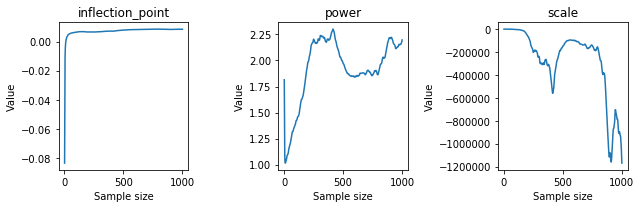

In [139]:
fig = plot_fit_params(null_params, ['inflection_point', 'power', 'scale'])

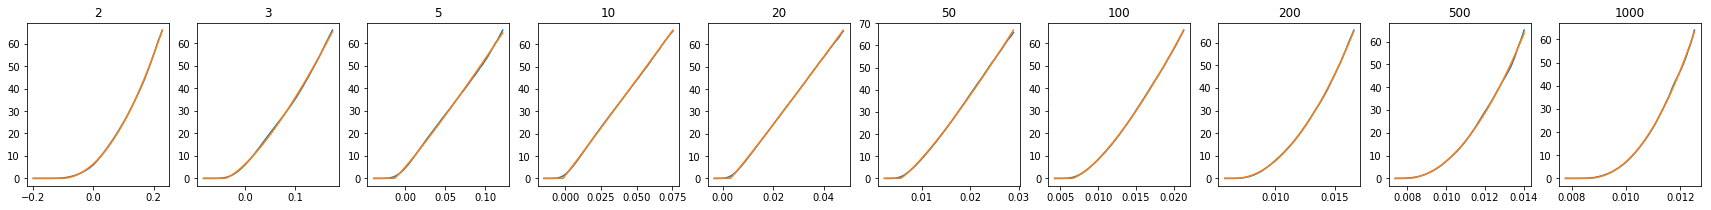

In [142]:
REGION_SIZES = (2, 3, 5, 10, 20, 50, 100, 200, 500, 1000)
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
    empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
    pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = disro_class(*fit_distro_params)
    ax.plot(fit_xs, -10 * fit_ys)

    ax.plot(fit_xs, -10 * fit_distro.logsf(fit_xs))
    
    ax.set_title(region_size)

## Compare to Norm

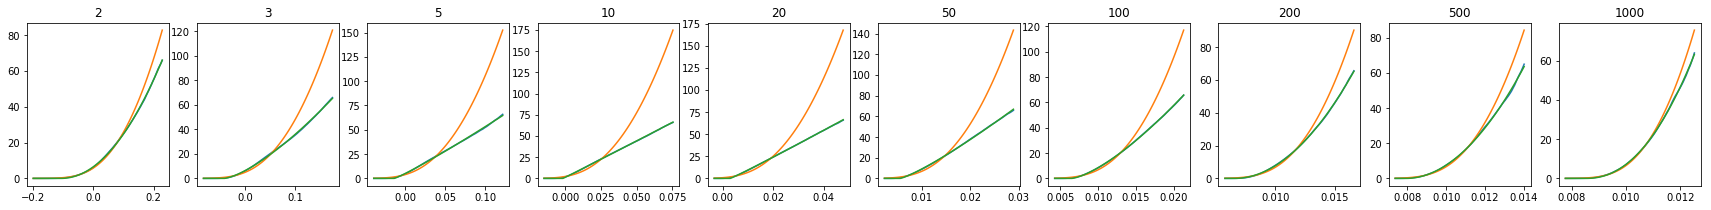

In [144]:
REGION_SIZES = (2, 3, 5, 10, 20, 50, 100, 200, 500, 1000)
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
#     empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
#     pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.plot(fit_xs, -10 * fit_ys)

    ax.plot(fit_xs, -10 * norm_distro.logsf(fit_xs))
    
    ax.plot(fit_xs, -10 * fit_distro.logsf(fit_xs))
    
    
    ax.set_title(region_size)

## Q-Q plot

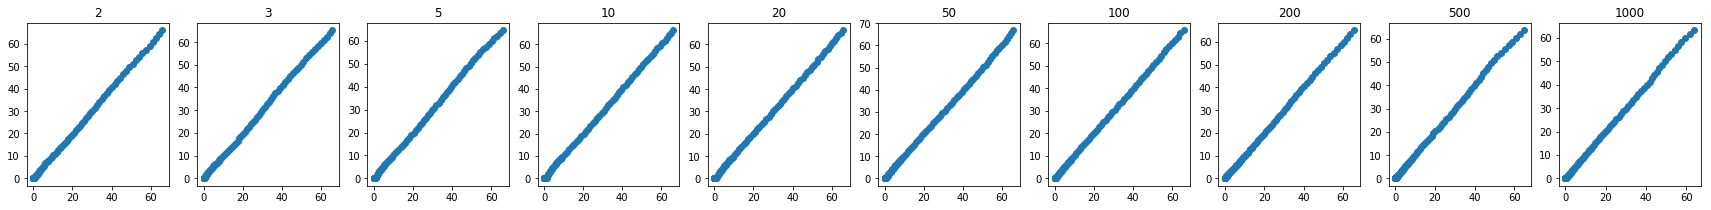

In [145]:
REGION_SIZES = (2, 3, 5, 10, 20, 50, 100, 200, 500, 1000)
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
#     empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
#     pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.scatter(-10*fit_ys, -10 * fit_distro.logsf(fit_xs))

#     ax.plot(fit_xs, -10 * norm_distro.logsf(fit_xs))
    
#     ax.plot(fit_xs, -10 * fit_distro.logsf(fit_xs))
    
    
    ax.set_title(region_size)

In [149]:
def square_ax(ax):
    joint_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    joint_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim((joint_min, joint_max))
    ax.set_ylim((joint_min, joint_max))

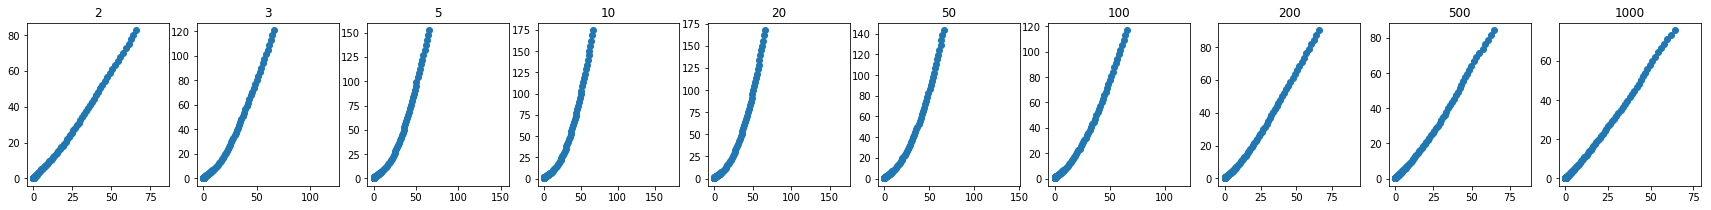

In [150]:
REGION_SIZES = (2, 3, 5, 10, 20, 50, 100, 200, 500, 1000)
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
#     empirical_pvals = empdist.empirical_pval.compute_empirical_pvalue(region_means, xs, is_sorted=True, tail='right')
#     pscores = -10 * numpy.log(empirical_pvals)
#     ax.plot(xs, pscores)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.scatter(-10*fit_ys, -10 * norm_distro.logsf(fit_xs))
    square_ax(ax)

    ax.set_title(region_size)

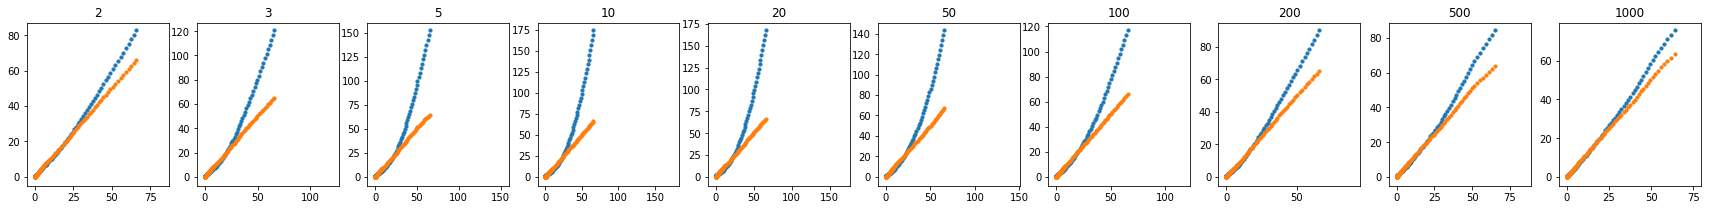

In [154]:
REGION_SIZES = (2, 3, 5, 10, 20, 50, 100, 200, 500, 1000)
distro_class = peas.fitapproxdistros.distributions.PiecewiseApproxPower

fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means[region_size]
    xs = numpy.linspace(0, 0.2)
    
    fit_xs, fit_ys = distro_class._compute_empirical_logsf(region_means, is_sorted=True)
    fit_distro_params = distro_class.fit(region_means, is_sorted=True)
    fit_distro = distro_class(*fit_distro_params)
    
    norm_params = scipy.stats.norm.fit(region_means)
    norm_distro = scipy.stats.norm(*norm_params)
    
    ax.scatter(-10*fit_ys, -10 * norm_distro.logsf(fit_xs), s=10)
    ax.scatter(-10*fit_ys, -10 * fit_distro.logsf(fit_xs), s=10)

    square_ax(ax)

    ax.set_title(region_size)

## Generate distributions and move on

In [101]:
null_distributions = peas.region_stats.fit_distributions(shuffled_means,
                                                         distribution_class=peas.fitapproxdistros.distributions.PiecewiseApproxPower, parameter_smoothing_window_size=0)

2018-Aug-30 13:13:44		Fitting distributions of class <class 'peas.fitapproxdistros.distributions.PiecewiseApproxPower'>
2018-Aug-30 13:13:44			size: 2 fit parameters: (-0.10658309585899596, 2.032901823792383, -60.81773561582572)
2018-Aug-30 13:13:44			size: 3 fit parameters: (-0.0420821811933288, 1.4098987942176724, -56.47446958697167)
2018-Aug-30 13:13:45			size: 4 fit parameters: (-0.022828795463130786, 1.2130307655485628, -58.657163620754815)
2018-Aug-30 13:13:45			size: 5 fit parameters: (-0.013626005194023722, 1.1074855645214225, -60.397348177432434)
2018-Aug-30 13:13:45			size: 6 fit parameters: (-0.00889373067444305, 1.0589194244967761, -64.35094671746047)
2018-Aug-30 13:13:45			size: 7 fit parameters: (-0.005997699944623619, 1.0352588799589428, -69.5957595348454)
2018-Aug-30 13:13:45			size: 8 fit parameters: (-0.003936862033668319, 1.0179536372383708, -74.67511699088759)
2018-Aug-30 13:13:45			size: 9 fit parameters: (-0.0027080959229235924, 1.0209716657578265, -82.77422399481

2018-Aug-30 13:13:50			size: 75 fit parameters: (0.006177945344378153, 1.318606090295176, -1327.5850937657654)
2018-Aug-30 13:13:50			size: 76 fit parameters: (0.006193827355532281, 1.3231291425449736, -1370.0666827885875)
2018-Aug-30 13:13:50			size: 77 fit parameters: (0.00621639980954856, 1.3257387105767011, -1397.8786966012374)
2018-Aug-30 13:13:50			size: 78 fit parameters: (0.006222882771764836, 1.3320209647958279, -1454.844686762412)
2018-Aug-30 13:13:50			size: 79 fit parameters: (0.006242606557023013, 1.3345726493910985, -1485.59309223289)
2018-Aug-30 13:13:50			size: 80 fit parameters: (0.006254499141539368, 1.3394925586238202, -1538.733298688542)
2018-Aug-30 13:13:50			size: 81 fit parameters: (0.006270200106359309, 1.3427475440138492, -1577.8549993342021)
2018-Aug-30 13:13:50			size: 82 fit parameters: (0.006285318911923022, 1.346335806204371, -1619.2415945092143)
2018-Aug-30 13:13:51			size: 83 fit parameters: (0.006312642086296844, 1.346949542037884, -1638.6840523377584)


2018-Aug-30 13:13:56			size: 150 fit parameters: (0.006828512270218935, 1.6229825871081185, -9166.911244311068)
2018-Aug-30 13:13:56			size: 151 fit parameters: (0.006830833633534683, 1.6272779393084305, -9401.093461337248)
2018-Aug-30 13:13:56			size: 152 fit parameters: (0.006833009954081758, 1.631574526202604, -9666.448549090717)
2018-Aug-30 13:13:56			size: 153 fit parameters: (0.006843836063365274, 1.6326592781308114, -9753.902301760025)
2018-Aug-30 13:13:56			size: 154 fit parameters: (0.006853083281464798, 1.6340028781398104, -9919.006312116495)
2018-Aug-30 13:13:56			size: 155 fit parameters: (0.006850518801000771, 1.6400685007478053, -10296.873801181444)
2018-Aug-30 13:13:56			size: 156 fit parameters: (0.006867248882833494, 1.6384258979003337, -10287.20173034986)
2018-Aug-30 13:13:56			size: 157 fit parameters: (0.00686822819627052, 1.6429059796987013, -10515.610421753854)
2018-Aug-30 13:13:56			size: 158 fit parameters: (0.0068541567982627685, 1.653478392897694, -11067.06426

2018-Aug-30 13:14:01			size: 225 fit parameters: (0.006585727752012365, 2.0931389912916387, -111870.6716765843)
2018-Aug-30 13:14:01			size: 226 fit parameters: (0.006558148501438206, 2.1105928903643414, -121458.06393508406)
2018-Aug-30 13:14:01			size: 227 fit parameters: (0.006527249106557772, 2.1296430061370692, -133094.5702659398)
2018-Aug-30 13:14:02			size: 228 fit parameters: (0.006510686257487074, 2.1415691621065194, -140226.7737164691)
2018-Aug-30 13:14:02			size: 229 fit parameters: (0.0065163158339304385, 2.143337751020763, -142490.464220015)
2018-Aug-30 13:14:02			size: 230 fit parameters: (0.006524758355006542, 2.144348465487742, -144426.92354157995)
2018-Aug-30 13:14:02			size: 231 fit parameters: (0.006533425517789038, 2.1444193345742932, -145324.82551754263)
2018-Aug-30 13:14:02			size: 232 fit parameters: (0.0065277320943417155, 2.151498760967721, -149416.23067615737)
2018-Aug-30 13:14:02			size: 233 fit parameters: (0.006519429680434021, 2.159016269578231, -156040.634

2018-Aug-30 13:14:07			size: 300 fit parameters: (0.006886167326174998, 2.1958273310244754, -243054.17932775556)
2018-Aug-30 13:14:07			size: 301 fit parameters: (0.006898608948947575, 2.192131795983645, -238852.98730095834)
2018-Aug-30 13:14:07			size: 302 fit parameters: (0.0068822051018350245, 2.2037537972970553, -253418.9384770427)
2018-Aug-30 13:14:07			size: 303 fit parameters: (0.00688137098441955, 2.206975864295034, -257338.0254211989)
2018-Aug-30 13:14:07			size: 304 fit parameters: (0.006851681515610624, 2.225334145832183, -280548.37342797394)
2018-Aug-30 13:14:07			size: 305 fit parameters: (0.006846334744668719, 2.2314562070666786, -287894.61210111016)
2018-Aug-30 13:14:07			size: 306 fit parameters: (0.006835604328937713, 2.23941005509497, -301490.7242180117)
2018-Aug-30 13:14:07			size: 307 fit parameters: (0.006837480338403645, 2.2410313265105635, -305715.5849087633)
2018-Aug-30 13:14:08			size: 308 fit parameters: (0.006844799834930212, 2.239440006520085, -303285.501313

2018-Aug-30 13:14:13			size: 375 fit parameters: (0.007209893363179826, 2.2033847645888502, -326461.21469264297)
2018-Aug-30 13:14:13			size: 376 fit parameters: (0.007219549616428742, 2.1997628788320953, -321689.6583907622)
2018-Aug-30 13:14:13			size: 377 fit parameters: (0.007220847041751744, 2.2014491531607185, -324868.8407339909)
2018-Aug-30 13:14:13			size: 378 fit parameters: (0.007241245168932555, 2.1915887865102213, -312636.80332557333)
2018-Aug-30 13:14:13			size: 379 fit parameters: (0.007245472742815847, 2.191334725865241, -312324.03626108787)
2018-Aug-30 13:14:13			size: 380 fit parameters: (0.007247097066466119, 2.192666406120483, -316057.89606686926)
2018-Aug-30 13:14:13			size: 381 fit parameters: (0.007254906541803876, 2.190255187131987, -314431.97627528035)
2018-Aug-30 13:14:13			size: 382 fit parameters: (0.007239692790458228, 2.2021339226332293, -331598.4842496193)
2018-Aug-30 13:14:13			size: 383 fit parameters: (0.007244517179235791, 2.2012013421881163, -330104.68

2018-Aug-30 13:14:18			size: 450 fit parameters: (0.007584021647510051, 2.130093361015688, -287158.12430143624)
2018-Aug-30 13:14:18			size: 451 fit parameters: (0.007597267586223728, 2.1227568607783396, -278871.043494606)
2018-Aug-30 13:14:18			size: 452 fit parameters: (0.007608487019879196, 2.117178550866681, -272806.08200403437)
2018-Aug-30 13:14:19			size: 453 fit parameters: (0.007608515125124562, 2.1190477244538597, -275167.0985369475)
2018-Aug-30 13:14:19			size: 454 fit parameters: (0.007610913399867405, 2.119412948125472, -277019.2956569043)
2018-Aug-30 13:14:19			size: 455 fit parameters: (0.0076179880141161605, 2.116541501167717, -273518.22130904876)
2018-Aug-30 13:14:19			size: 456 fit parameters: (0.007622123537512887, 2.115782167617459, -273162.89103348396)
2018-Aug-30 13:14:19			size: 457 fit parameters: (0.007635618586198837, 2.108796604996787, -264412.8204621183)
2018-Aug-30 13:14:19			size: 458 fit parameters: (0.007650013689064082, 2.101072504517209, -254827.5036698

2018-Aug-30 13:14:25			size: 525 fit parameters: (0.008088419402148293, 1.9007624016448914, -114586.24190022252)
2018-Aug-30 13:14:26			size: 526 fit parameters: (0.008089824866856424, 1.901302940158951, -114689.95145594802)
2018-Aug-30 13:14:26			size: 527 fit parameters: (0.008100525574549402, 1.8954422641362074, -112016.22513021878)
2018-Aug-30 13:14:26			size: 528 fit parameters: (0.008105014958512865, 1.8939179679389961, -111192.53368909497)
2018-Aug-30 13:14:26			size: 529 fit parameters: (0.00810751878512711, 1.893849727606862, -110944.1054245053)
2018-Aug-30 13:14:26			size: 530 fit parameters: (0.008113095471310255, 1.8914947097153678, -109893.8577199304)
2018-Aug-30 13:14:26			size: 531 fit parameters: (0.00811722536350655, 1.8901989850080405, -108951.52985530392)
2018-Aug-30 13:14:26			size: 532 fit parameters: (0.008127855572676888, 1.884033860874437, -106066.1851634946)
2018-Aug-30 13:14:26			size: 533 fit parameters: (0.008133625673893157, 1.8814003470941172, -104717.8215

2018-Aug-30 13:14:31			size: 601 fit parameters: (0.008320600240890376, 1.8501222888710482, -103297.71044263519)
2018-Aug-30 13:14:31			size: 602 fit parameters: (0.008322405035200754, 1.8504181450420738, -103862.94429667247)
2018-Aug-30 13:14:31			size: 603 fit parameters: (0.008326697432197862, 1.8488723780111118, -103304.82307173718)
2018-Aug-30 13:14:31			size: 604 fit parameters: (0.008329284742657801, 1.8486638705570098, -103273.68663299739)
2018-Aug-30 13:14:31			size: 605 fit parameters: (0.008338124058074659, 1.8433289256472967, -100868.88918752843)
2018-Aug-30 13:14:31			size: 606 fit parameters: (0.008336141789789944, 1.846310521092041, -102297.33972888529)
2018-Aug-30 13:14:31			size: 607 fit parameters: (0.008344677942589055, 1.840811249947823, -99559.44358281905)
2018-Aug-30 13:14:31			size: 608 fit parameters: (0.008349337430845934, 1.8387478923849723, -98854.56656348033)
2018-Aug-30 13:14:31			size: 609 fit parameters: (0.008348134217347638, 1.8415299863871712, -100277.

2018-Aug-30 13:14:36			size: 677 fit parameters: (0.008434541079566702, 1.8814051721312908, -138886.47920474497)
2018-Aug-30 13:14:36			size: 678 fit parameters: (0.00844224404809914, 1.8765316242293368, -135478.35987181566)
2018-Aug-30 13:14:36			size: 679 fit parameters: (0.008441397840691721, 1.8787664605534806, -137210.12752789917)
2018-Aug-30 13:14:36			size: 680 fit parameters: (0.008447707785544618, 1.8751888565839983, -134780.59836925508)
2018-Aug-30 13:14:36			size: 681 fit parameters: (0.008449285626736103, 1.8754723741167085, -135019.71083738536)
2018-Aug-30 13:14:36			size: 682 fit parameters: (0.008453026971904006, 1.87380337911693, -134211.02639094353)
2018-Aug-30 13:14:36			size: 683 fit parameters: (0.008452825514817406, 1.8759079752318648, -135947.06563755262)
2018-Aug-30 13:14:36			size: 684 fit parameters: (0.008465916723085238, 1.866052640671743, -129319.41851068621)
2018-Aug-30 13:14:36			size: 685 fit parameters: (0.008471745315846308, 1.8624058582251273, -127159.

2018-Aug-30 13:14:40			size: 753 fit parameters: (0.008566734949290585, 1.8685535597076823, -145523.81699818268)
2018-Aug-30 13:14:40			size: 754 fit parameters: (0.008574557284134145, 1.86294379778839, -141520.8443288115)
2018-Aug-30 13:14:41			size: 755 fit parameters: (0.008575487634114974, 1.8631845407133314, -142071.74800217067)
2018-Aug-30 13:14:41			size: 756 fit parameters: (0.008564005537139296, 1.8748481543946964, -151195.50545467148)
2018-Aug-30 13:14:41			size: 757 fit parameters: (0.008563424701721589, 1.8760433819218068, -152561.9325897264)
2018-Aug-30 13:14:41			size: 758 fit parameters: (0.008564029284458695, 1.8765602170937112, -152989.82526788718)
2018-Aug-30 13:14:41			size: 759 fit parameters: (0.008562883355466127, 1.8788706588722393, -155236.6945430436)
2018-Aug-30 13:14:41			size: 760 fit parameters: (0.008559004793314944, 1.8835575343481978, -159536.52058565928)
2018-Aug-30 13:14:41			size: 761 fit parameters: (0.009788075100669142, 1.00000033636942, -1881.55332

2018-Aug-30 13:14:45			size: 829 fit parameters: (0.009807697837453107, 1.0000004550680088, -2024.0517884131689)
2018-Aug-30 13:14:45			size: 830 fit parameters: (0.008515721620201372, 2.0023936105606595, -327433.4084696326)
2018-Aug-30 13:14:45			size: 831 fit parameters: (0.00851564839710314, 2.003358867784217, -328986.17965538905)
2018-Aug-30 13:14:45			size: 832 fit parameters: (0.008509011257777263, 2.0113037204825455, -343330.20191315544)
2018-Aug-30 13:14:45			size: 833 fit parameters: (0.00850331622922454, 2.0177971433189716, -356264.8930897548)
2018-Aug-30 13:14:45			size: 834 fit parameters: (0.00850311295821183, 2.0195187363266687, -360169.5251067666)
2018-Aug-30 13:14:45			size: 835 fit parameters: (0.00849385834544391, 2.0293341996719954, -379673.6523739119)
2018-Aug-30 13:14:45			size: 836 fit parameters: (0.008493798142515966, 2.0305027597678444, -382880.3499036244)
2018-Aug-30 13:14:45			size: 837 fit parameters: (0.008499562518297636, 2.02605887441307, -374646.27573403

2018-Aug-30 13:14:50			size: 905 fit parameters: (0.008391589203970984, 2.216473571727458, -1103423.0199253608)
2018-Aug-30 13:14:50			size: 906 fit parameters: (0.008386880048262735, 2.222188474781869, -1139990.3644402474)
2018-Aug-30 13:14:50			size: 907 fit parameters: (0.008387537369569598, 2.2225107829009025, -1143156.6897743554)
2018-Aug-30 13:14:50			size: 908 fit parameters: (0.008385968863091717, 2.225376708743107, -1161424.8408016386)
2018-Aug-30 13:14:50			size: 909 fit parameters: (0.008392432769668104, 2.219845230412008, -1132359.9924597286)
2018-Aug-30 13:14:50			size: 910 fit parameters: (0.008395253409589838, 2.218354937376744, -1123880.3975005848)
2018-Aug-30 13:14:50			size: 911 fit parameters: (0.008393336277981438, 2.221349535836424, -1145310.3881231302)
2018-Aug-30 13:14:50			size: 912 fit parameters: (0.008390917471947191, 2.2252233411464144, -1171353.86554089)
2018-Aug-30 13:14:50			size: 913 fit parameters: (0.008405632279726603, 2.2114190715182294, -1092834.133

2018-Aug-30 13:14:54			size: 981 fit parameters: (0.008533747337504706, 2.153510724101026, -920518.4071603243)
2018-Aug-30 13:14:54			size: 982 fit parameters: (0.008538760153856441, 2.149442954899285, -901567.7962586313)
2018-Aug-30 13:14:54			size: 983 fit parameters: (0.00982760541622149, 1.000000764421964, -2339.3478540029996)
2018-Aug-30 13:14:54			size: 984 fit parameters: (0.008533977908736272, 2.156943224854771, -942331.3023656671)
2018-Aug-30 13:14:54			size: 985 fit parameters: (0.008534709858563597, 2.1567657303466765, -940523.993169506)
2018-Aug-30 13:14:55			size: 986 fit parameters: (0.008534524402188345, 2.158476790325906, -951985.1802538551)
2018-Aug-30 13:14:55			size: 987 fit parameters: (0.008536403112386987, 2.157068280296382, -948109.2997009762)
2018-Aug-30 13:14:55			size: 988 fit parameters: (0.00854171049791244, 2.1527031652673627, -926850.1492051553)
2018-Aug-30 13:14:55			size: 989 fit parameters: (0.008540549235598462, 2.155380881596823, -940615.3884627264)
2